In [1]:
import numpy 
import pandas
import cobra
from cobra.io import load_matlab_model, save_matlab_model, read_sbml_model, write_sbml_model, load_model, to_json
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.family':'sans-serif',
                            'font.size':20, 
                            'xtick.labelsize':30, 
                            'ytick.labelsize':30, 
                            'figure.figsize':(20, 10), 
                            'axes.labelsize':40})

import seaborn
from cobra import Model, Reaction, Metabolite
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from cobra.flux_analysis import pfba

## 1. Generate fluxes for 100 points on an Ecoli.core Model with decreasing oxygen

In [2]:
model = load_model('textbook')

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [3]:
model

Name,e_coli_core
Memory address,0x07f8e11935100
Number of metabolites,72
Number of reactions,95
Number of groups,0
Objective expression,1.0*Biomass_Ecoli_core - 1.0*Biomass_Ecoli_core_reverse_2cdba
Compartments,"cytosol, extracellular"


In [4]:
model.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
glc__D_e,EX_glc__D_e,10,6,100.00%
nh4_e,EX_nh4_e,4.765,0,0.00%
o2_e,EX_o2_e,21.8,0,0.00%
pi_e,EX_pi_e,3.215,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
co2_e,EX_co2_e,-22.81,1,100.00%
h2o_e,EX_h2o_e,-29.18,0,0.00%
h_e,EX_h_e,-17.53,0,0.00%


In [5]:
solution = model.optimize()
solution.objective_value

0.8739215069684304

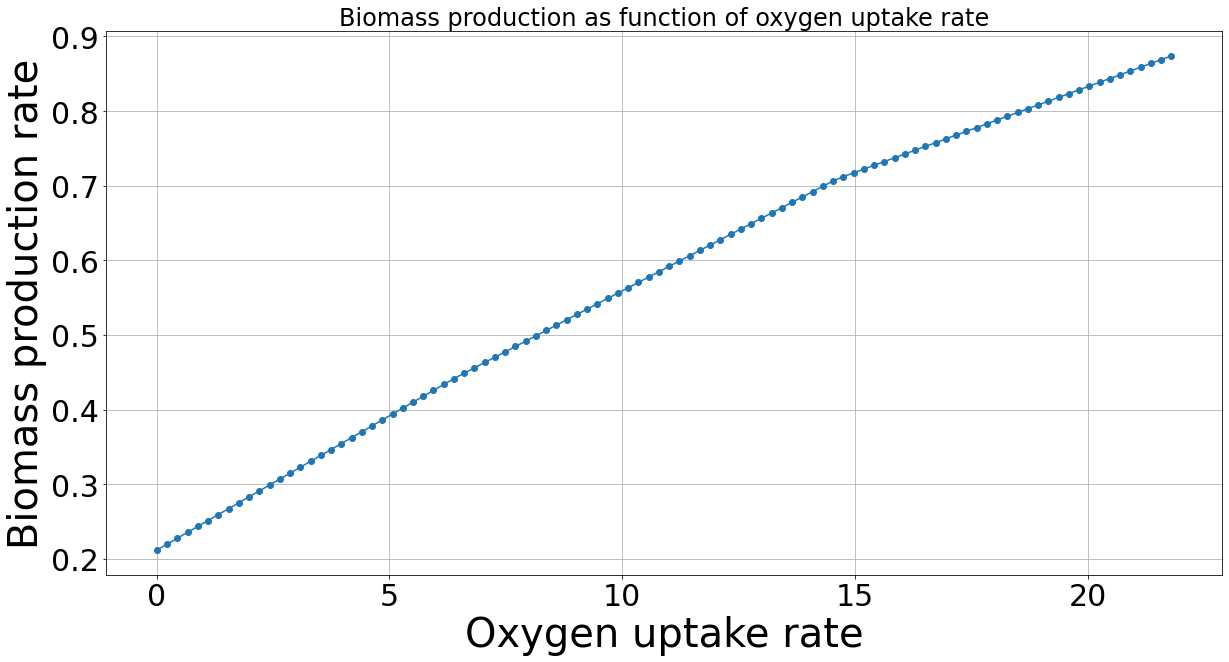

In [6]:
# higher_boundary
# model is exploring 21.8 units of o2
# Explore 100 points from 0 to 21.8 
# Then see impact of biomass
# x see impact of biomass
# do FBA and "pFBA"
# 
oxygen_fluxes = numpy.linspace(0, 21.8, 100)  

resulting_fluxes = []

for flux in oxygen_fluxes:
    model.reactions.EX_o2_e.lower_bound = -flux  # NOTE: the negative sign, uptake reactions are typically negative in cobra models
    solution = model.optimize()
    if solution.status == 'optimal':
        resulting_fluxes.append(solution.objective_value)
    else:
        resulting_fluxes.append(numpy.nan)

matplotlib.pyplot.figure(figsize = (20, 10))
matplotlib.pyplot.plot(oxygen_fluxes, resulting_fluxes, 'o-')  # added markers
matplotlib.pyplot.xlabel('Oxygen uptake rate')
matplotlib.pyplot.ylabel('Biomass production rate')
matplotlib.pyplot.title('Biomass production as function of oxygen uptake rate')
matplotlib.pyplot.grid(True)
matplotlib.pyplot.show()


In [7]:
oxygen_fluxes

array([ 0.        ,  0.22020202,  0.44040404,  0.66060606,  0.88080808,
        1.1010101 ,  1.32121212,  1.54141414,  1.76161616,  1.98181818,
        2.2020202 ,  2.42222222,  2.64242424,  2.86262626,  3.08282828,
        3.3030303 ,  3.52323232,  3.74343434,  3.96363636,  4.18383838,
        4.4040404 ,  4.62424242,  4.84444444,  5.06464646,  5.28484848,
        5.50505051,  5.72525253,  5.94545455,  6.16565657,  6.38585859,
        6.60606061,  6.82626263,  7.04646465,  7.26666667,  7.48686869,
        7.70707071,  7.92727273,  8.14747475,  8.36767677,  8.58787879,
        8.80808081,  9.02828283,  9.24848485,  9.46868687,  9.68888889,
        9.90909091, 10.12929293, 10.34949495, 10.56969697, 10.78989899,
       11.01010101, 11.23030303, 11.45050505, 11.67070707, 11.89090909,
       12.11111111, 12.33131313, 12.55151515, 12.77171717, 12.99191919,
       13.21212121, 13.43232323, 13.65252525, 13.87272727, 14.09292929,
       14.31313131, 14.53333333, 14.75353535, 14.97373737, 15.19

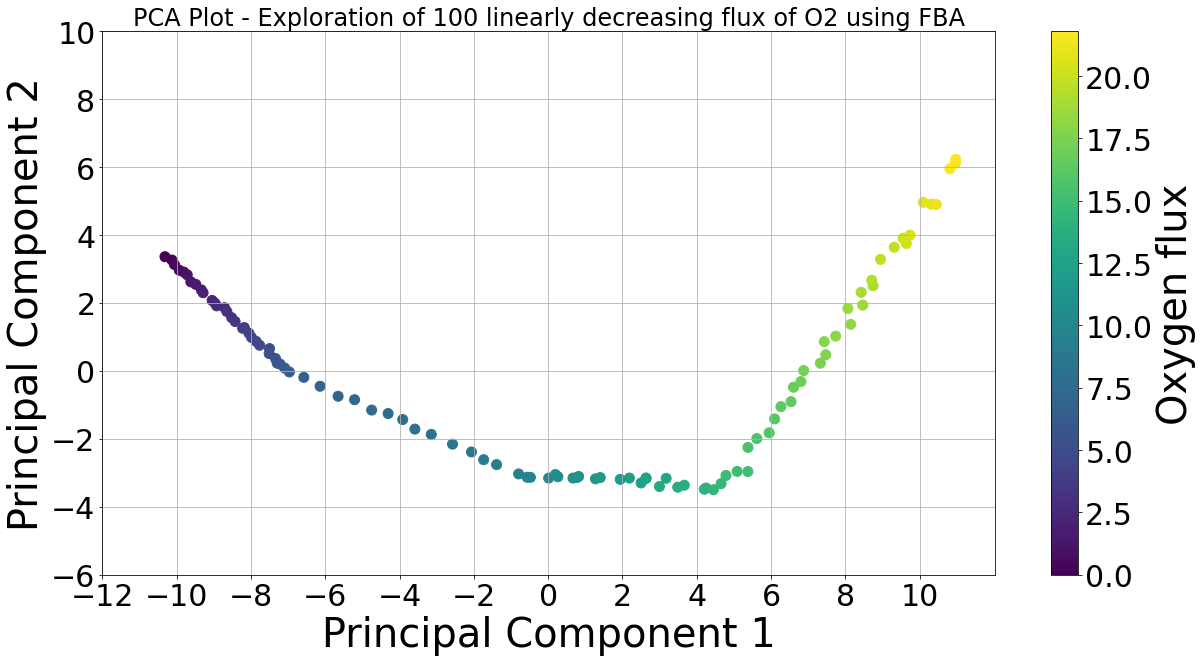

In [8]:
all_fluxes = []
oxygen_fluxes_after_fba = []

for flux in oxygen_fluxes:
    model.reactions.EX_o2_e.lower_bound = -flux
    solution = model.optimize()  # FBA
    if solution:
        all_fluxes.append(solution.fluxes)
        oxygen_fluxes_after_fba.append(numpy.abs(solution.fluxes['EX_o2_e']))
    else:
        all_fluxes.append([numpy.nan]*len(model.reactions))
        oxygen_fluxes_after_fba.append(numpy.nan)

df = pandas.DataFrame(all_fluxes, columns=[r.id for r in model.reactions])

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df.fillna(0))

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(scaled_df) 
principalDf = pandas.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

fig, ax = matplotlib.pyplot.subplots(figsize = (20, 10))
scatter = ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'],
                     c = oxygen_fluxes_after_fba, cmap = 'viridis', s = 100) # using oxygen_fluxes for color


x_ticks = numpy.arange(-12, 12, step=2)
y_ticks = numpy.arange(-6, 12, step=2)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA Plot - Exploration of 100 linearly decreasing flux of O2 using FBA')
fig.colorbar(scatter, ax = ax, label = 'Oxygen flux')
ax.grid(True)
matplotlib.pyplot.show()

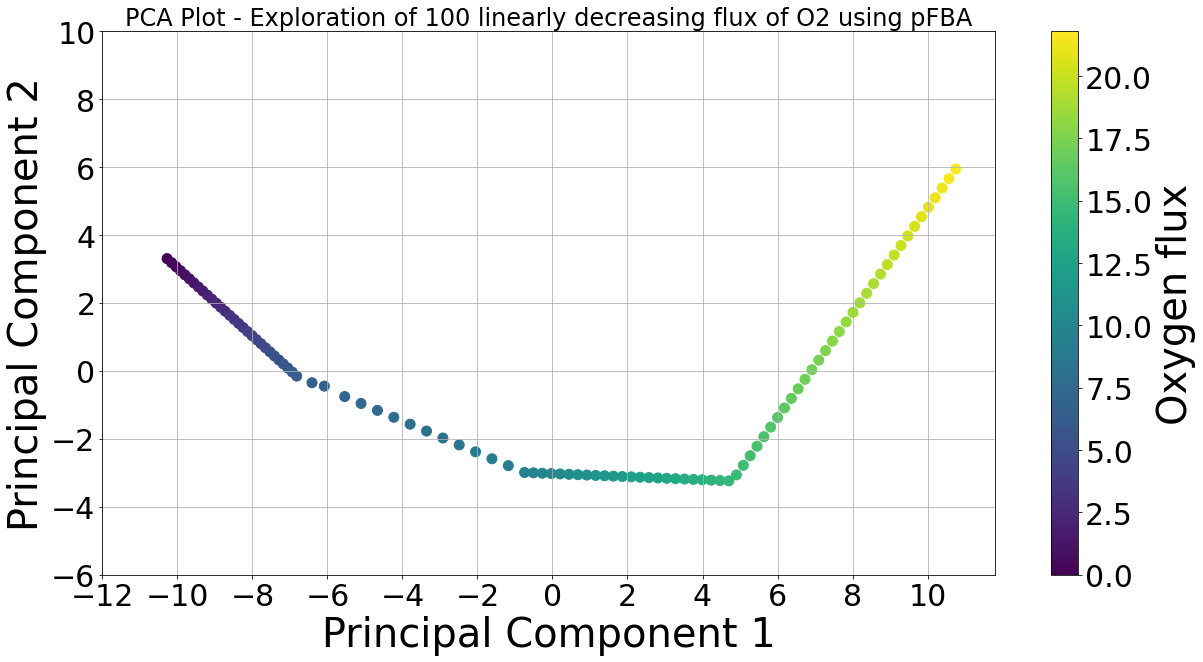

In [9]:
all_fluxes = []
oxygen_fluxes_after_pfba = []

for flux in oxygen_fluxes:
    model.reactions.EX_o2_e.lower_bound = -flux
    solution = pfba(model)  # pFBA
    if solution:
        all_fluxes.append(solution.fluxes)
        oxygen_fluxes_after_pfba.append(numpy.abs(solution.fluxes['EX_o2_e']))
    else:
        all_fluxes.append([numpy.nan]*len(model.reactions))
        oxygen_fluxes_after_pfba.append(numpy.nan)

df = pandas.DataFrame(all_fluxes, columns=[r.id for r in model.reactions])

scaler = StandardScaler()
scaled_df = scaler.fit_transform(df.fillna(0))

pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(scaled_df) 
principalDf = pandas.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

fig, ax = matplotlib.pyplot.subplots(figsize = (20, 10))
scatter = ax.scatter(principalDf['principal component 1'], principalDf['principal component 2'],
                     c = oxygen_fluxes_after_pfba, cmap = 'viridis', s = 100) # using oxygen_fluxes for color


x_ticks = numpy.arange(-12, 12, step=2)
y_ticks = numpy.arange(-6, 12, step=2)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('PCA Plot - Exploration of 100 linearly decreasing flux of O2 using pFBA')
fig.colorbar(scatter, ax = ax, label = 'Oxygen flux')
ax.grid(True)
matplotlib.pyplot.show()

#abs val of fluxes

In [10]:
loadings = pandas.DataFrame(pca.components_.T, columns = ['PC1', 'PC2'], index = df.columns)

# Rank reactions based on absolute loading, since loading can be negative, 
# and a large negative value is also influential.
loadings['PC1_rank'] = loadings['PC1'].abs().rank(ascending=False)
loadings['PC2_rank'] = loadings['PC2'].abs().rank(ascending=False)

# Sort by rank
loadings_sorted_PC1 = loadings.sort_values(by = 'PC1_rank')
loadings_sorted_PC2 = loadings.sort_values(by = 'PC2_rank')

print(loadings_sorted_PC1)
print(loadings_sorted_PC2)


                  PC1       PC2  PC1_rank  PC2_rank
ATPS4r       0.145289 -0.000995       1.0      57.0
H2Ot        -0.144748 -0.005315       2.5      55.5
EX_h2o_e     0.144748  0.005315       2.5      55.5
NADH16       0.144469 -0.011821       4.0      43.0
O2t          0.144341  0.018371       6.0      40.0
...               ...       ...       ...       ...
MALS         0.000000 -0.000000      77.5      77.5
MALt2_2      0.000000 -0.000000      77.5      77.5
EX_mal__L_e  0.000000 -0.000000      77.5      77.5
GLNabc       0.000000 -0.000000      77.5      77.5
ME1          0.000000 -0.000000      77.5      77.5

[95 rows x 4 columns]
             PC1       PC2  PC1_rank  PC2_rank
MDH     0.107349  0.250223      51.0       3.0
AKGDH   0.107349  0.250223      51.0       3.0
SUCOAS -0.107349 -0.250223      51.0       3.0
FUM     0.107349  0.250223      51.0       3.0
SUCDi   0.107349  0.250223      51.0       3.0
...          ...       ...       ...       ...
FRD7    0.000000 -0.0000

In [11]:
print("Top 20 fluxes for PC1:")
print(loadings_sorted_PC1.head(20))

print('____________________________________________________________________________')

print("\nTop 20 fluxes for PC2:")
print(loadings_sorted_PC2.head(20))


Top 20 fluxes for PC1:
                         PC1       PC2  PC1_rank  PC2_rank
ATPS4r              0.145289 -0.000995       1.0      57.0
H2Ot               -0.144748 -0.005315       2.5      55.5
EX_h2o_e            0.144748  0.005315       2.5      55.5
NADH16              0.144469 -0.011821       4.0      43.0
O2t                 0.144341  0.018371       6.0      40.0
EX_o2_e            -0.144341 -0.018371       6.0      40.0
CYTBD               0.144341  0.018371       6.0      40.0
PPC                 0.144237 -0.011738       8.5      45.0
Biomass_Ecoli_core  0.144237 -0.011738       8.5      44.0
GLNS                0.144237 -0.011738      11.0      46.0
NH4t                0.144237 -0.011738      11.0      47.5
EX_nh4_e           -0.144237  0.011738      11.0      47.5
EX_pi_e            -0.144237  0.011738      14.0      50.5
PIt2r               0.144237 -0.011738      14.0      50.5
GLUDy              -0.144237  0.011738      14.0      49.0
PYK                -0.143802  0.0

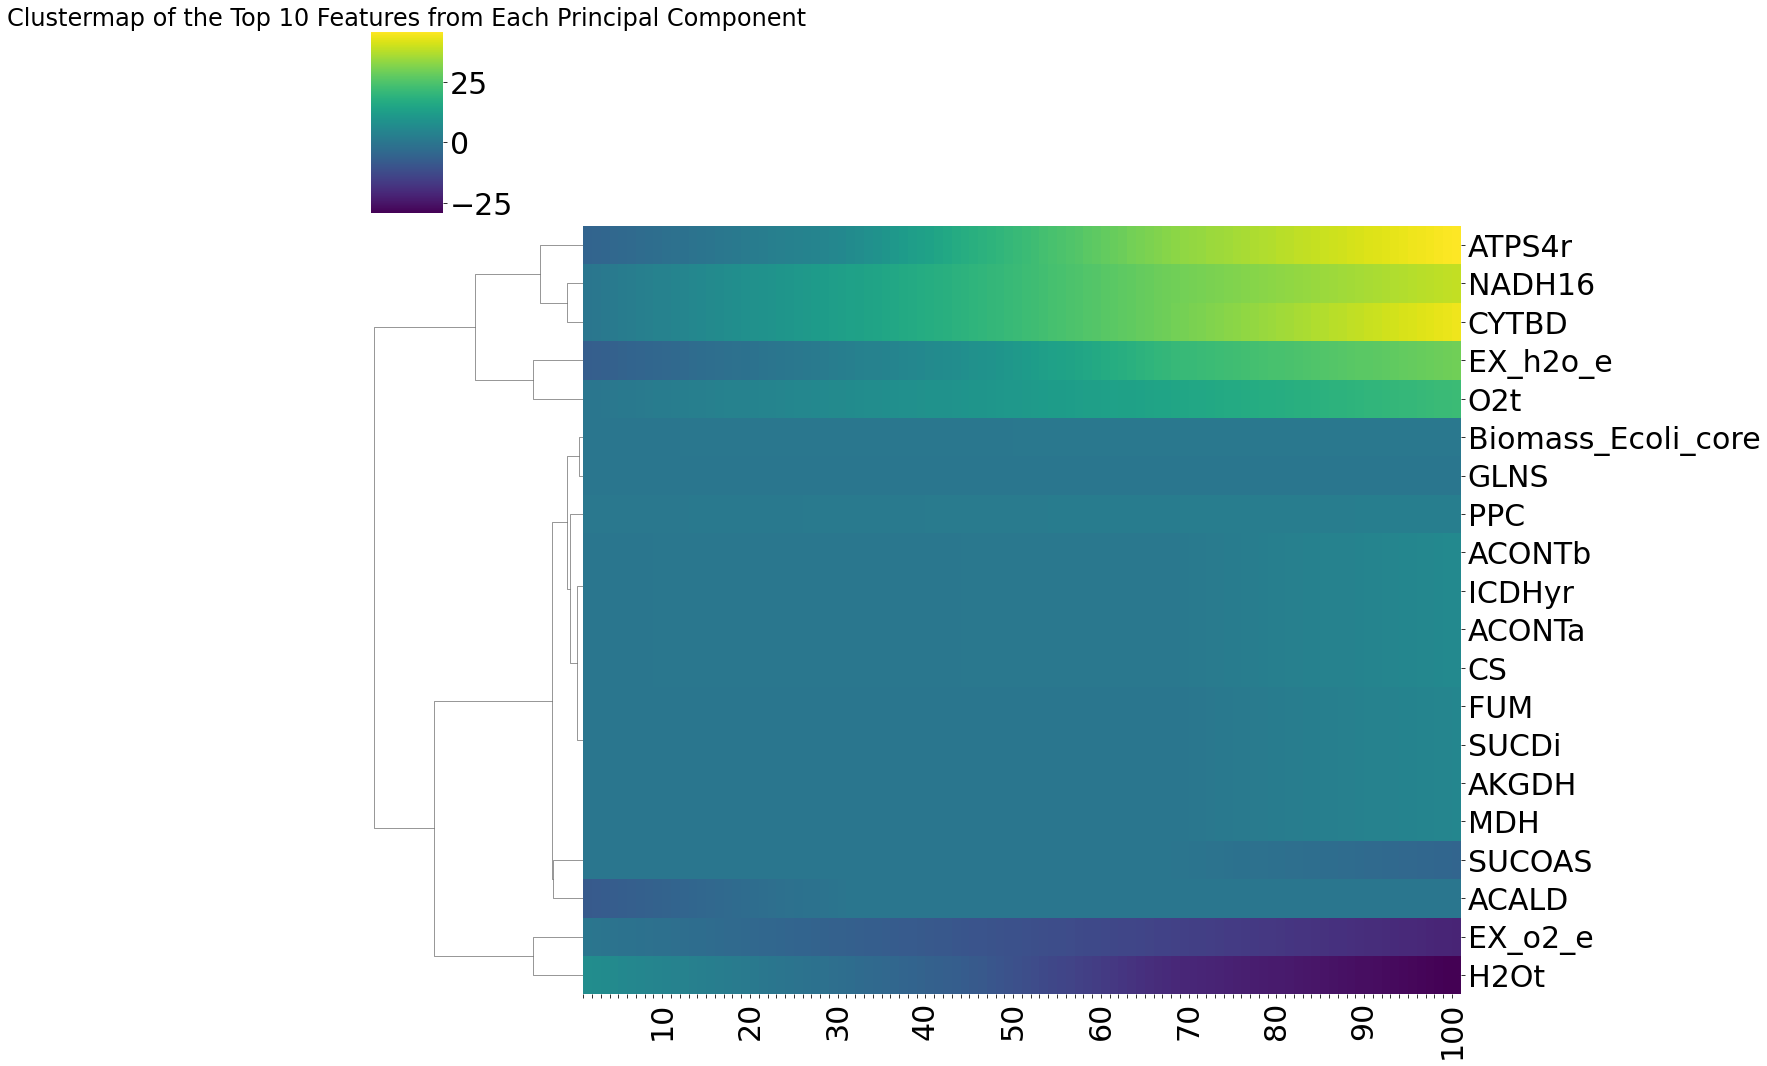

In [34]:
top_reactions_PC1 = loadings_sorted_PC1.index[:10].tolist()
top_reactions_PC2 = loadings_sorted_PC2.index[:10].tolist()

top_reactions = list(set(top_reactions_PC1 + top_reactions_PC2))

top_flux_data = df[top_reactions].transpose()

g = seaborn.clustermap(top_flux_data, cmap = 'viridis', col_cluster = False, 
               yticklabels = True, xticklabels = False, figsize = (20, 14))

labels = [str(i) if i % 10 == 0 else '' for i in range(1, 101)] 

g.ax_heatmap.set_xticks(numpy.arange(100))
g.ax_heatmap.set_xticklabels(labels, rotation = 90)

matplotlib.pyplot.title('Clustermap of the Top 10 Features from Each Principal Component')

matplotlib.pyplot.show()
#row fluxes
#columns would be the 100 simulations
#use clustermap from seaborn


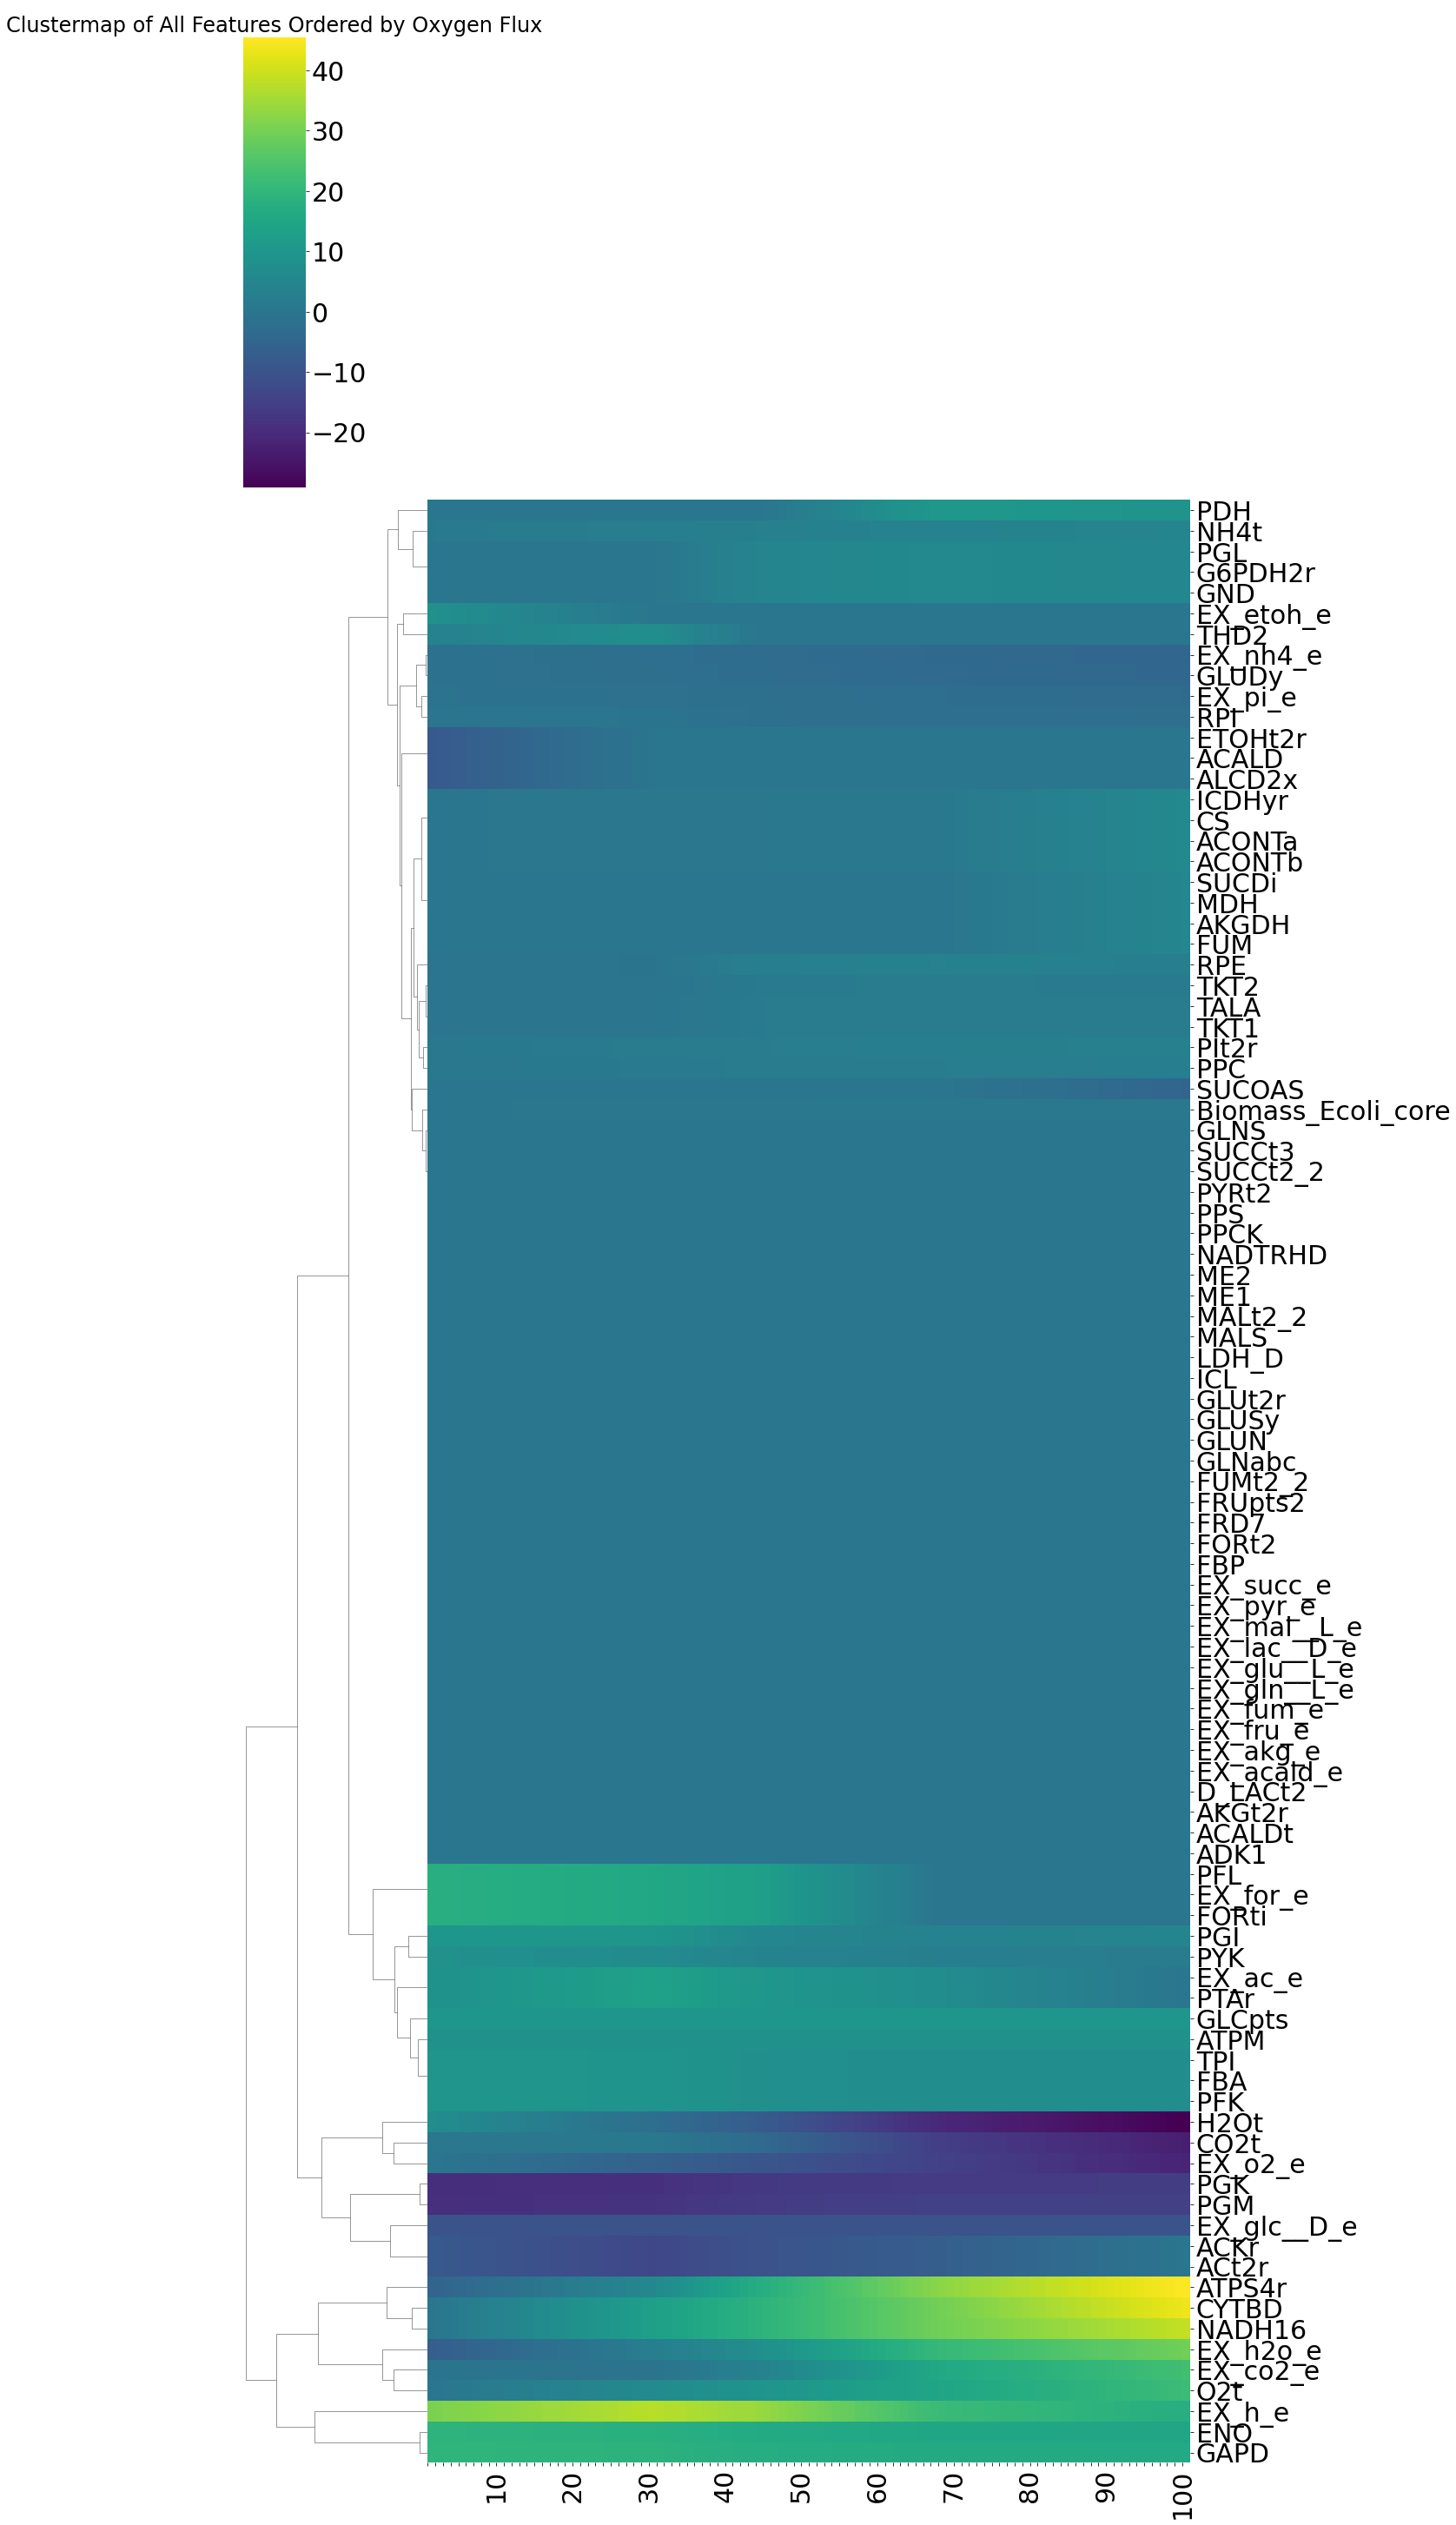

In [38]:
all_flux_data = df.transpose()  

g = seaborn.clustermap(all_flux_data, cmap = 'viridis', col_cluster = False, 
               yticklabels = True, xticklabels = False, figsize = (20, 40))

labels = [str(i) if i % 10 == 0 else '' for i in range(1, 101)] 

g.ax_heatmap.set_xticks(numpy.arange(100))
g.ax_heatmap.set_xticklabels(labels, rotation = 90)

matplotlib.pyplot.title('Clustermap of All Features')
matplotlib.pyplot.show()
# Why is the ordering different here?